In [7]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu
!pip install numpy matplotlib scipy librosa num2words==0.5.13 tqdm==4.66.1

Looking in indexes: https://download.pytorch.org/whl/cpu


In [1]:
import os
import matplotlib.pyplot as plt
import librosa

ERROR! Session/line number was not unique in database. History logging moved to new session 36


In [2]:
AUDIO_FILE_SAMPLE = 'samples/lesmis_0001.wav'
TEXT_FILE_SAMPLE = 'samples/transcription.txt'

### Traitement de texte

In [23]:
def read_text(file_path):
    with open(file_path, mode='r', encoding='utf-8') as file:
        return file.read()

### Traitement du song

In [3]:
def read_audio_signal(file_path, sample_rate=44100):
    assert file_path, "The file path is not defined."
    assert sample_rate, "The sample rate is not defined."
    if not os.path.isfile(file_path):
        raise FileNotFoundError(f"No such audio file at {file_path}")
    signal, _ = librosa.load(file_path, sr=sample_rate, mono=False)
    return signal

In [4]:
signal_sample = read_audio_signal(AUDIO_FILE_SAMPLE)
print(signal_sample.shape)

(336600,)


In [5]:
def show_audio_signal(signal):
    assert len(signal) > 0, "Signal values are not defined"
    plt.figure()
    plt.plot(signal)
    plt.title("Audio signal")
    plt.show()

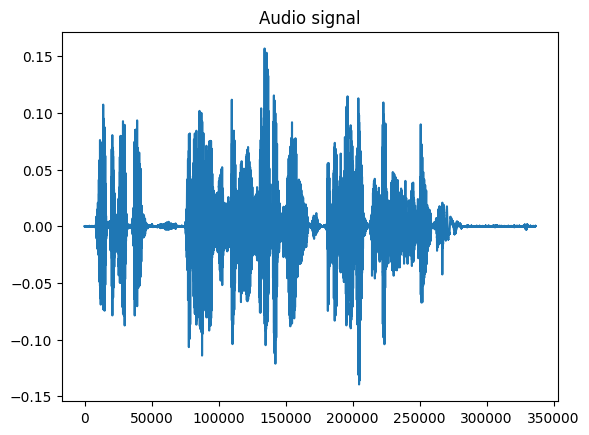

In [6]:
show_audio_signal(signal_sample)

In [19]:
import numpy as np
from scipy.signal import get_window
from librosa.util import normalize, pad_center

def window_sum_square(window, n_frames, hop_length=200, win_length=800,
                      n_fft=800, dtype=np.float32, norm=None):
    """
    Compute the sum-square envelope of a window function
    at a given hop length.

    This is used to estimate modulation effects induced by windowing
    observations in short-time fourier transforms.

    :param window: Window specification, as in `get_window`.
    :param n_frames: The number of analysis frames.
    :param hop_length: The number of samples to advance between frames.
    :param win_length: The length of the window function.
        By default, this matches `n_fft`.
    :param n_fft: The length of each analysis frame.
    :param dtype: The data type of the output.
    
    :return: The sum-squared envelope of the window function.
        shape: `(n_fft + hop_length * (n_frames - 1))`.
    :rtype: `np.ndarray`
    """
    if win_length is None:
        win_length = n_fft
    n = n_fft + hop_length * (n_frames - 1)
    x = np.zeros(n, dtype=dtype)

    # Compute the squared window at the desired length
    win_sq = get_window(window, win_length, fftbins=True)
    win_sq = normalize(win_sq, norm=norm)**2
    win_sq = pad_center(win_sq, size=n_fft)

    # Fill the develope
    for i in range(n_frames):
        sample = i * hop_length
        min_val1 = min(n, sample + n_fft)
        min_val2 = min(n_fft, n - sample)
        x[sample:min_val1] += win_sq[:max(0, min_val2)]
    return x

In [20]:
import torch
import numpy as np
import torch.nn.functional as F
from torch.autograd import Variable
from scipy.signal import get_window
from librosa.util import pad_center, tiny


class STFT(torch.nn.Module):
    """adapted from Prem Seetharaman's https://github.com/pseeth/pytorch-stft"""
    def __init__(self, filter_length=800, hop_length=200, win_length=800,
                 window='hann'):
        super(STFT, self).__init__()
        self.filter_length = filter_length
        self.hop_length = hop_length
        self.win_length = win_length
        self.window = window
        self.forward_transform = None
        scale = self.filter_length / self.hop_length
        fourier_basis = np.fft.fft(np.eye(self.filter_length))

        cutoff = int((self.filter_length / 2 + 1))
        fourier_basis = np.vstack([np.real(fourier_basis[:cutoff, :]),
                                   np.imag(fourier_basis[:cutoff, :])])

        forward_basis = torch.FloatTensor(fourier_basis[:, None, :])
        inverse_basis = torch.FloatTensor(
            np.linalg.pinv(scale * fourier_basis).T[:, None, :])

        if window is not None:
            assert(filter_length >= win_length)
            # get window and zero center pad it to filter_length
            fft_window = get_window(window, win_length, fftbins=True)
            fft_window = pad_center(fft_window, size=filter_length)
            fft_window = torch.from_numpy(fft_window).float()

            # window the bases
            forward_basis *= fft_window
            inverse_basis *= fft_window

        self.register_buffer('forward_basis', forward_basis.float())
        self.register_buffer('inverse_basis', inverse_basis.float())

    def transform(self, input_data):
        num_batches = input_data.size(0)
        num_samples = input_data.size(1)

        self.num_samples = num_samples

        # similar to librosa, reflect-pad the input
        input_data = input_data.view(num_batches, 1, num_samples)
        input_data = F.pad(
            input_data.unsqueeze(1),
            (int(self.filter_length / 2), int(self.filter_length / 2), 0, 0),
            mode='reflect')
        input_data = input_data.squeeze(1)

        forward_transform = F.conv1d(
            input_data,
            Variable(self.forward_basis, requires_grad=False),
            stride=self.hop_length,
            padding=0)

        cutoff = int((self.filter_length / 2) + 1)
        real_part = forward_transform[:, :cutoff, :]
        imag_part = forward_transform[:, cutoff:, :]

        magnitude = torch.sqrt(real_part**2 + imag_part**2)
        phase = torch.autograd.Variable(
            torch.atan2(imag_part.data, real_part.data))

        return magnitude, phase

    def inverse(self, magnitude, phase):
        recombine_magnitude_phase = torch.cat(
            [magnitude*torch.cos(phase), magnitude*torch.sin(phase)], dim=1)

        inverse_transform = F.conv_transpose1d(
            recombine_magnitude_phase,
            Variable(self.inverse_basis, requires_grad=False),
            stride=self.hop_length,
            padding=0)

        if self.window is not None:
            window_sum = window_sumsquare(
                self.window, magnitude.size(-1), hop_length=self.hop_length,
                win_length=self.win_length, n_fft=self.filter_length,
                dtype=np.float32)
            # remove modulation effects
            approx_nonzero_indices = torch.from_numpy(
                np.where(window_sum > tiny(window_sum))[0])
            window_sum = torch.autograd.Variable(
                torch.from_numpy(window_sum), requires_grad=False)
            window_sum = window_sum.cuda() if magnitude.is_cuda else window_sum
            inverse_transform[:, :, approx_nonzero_indices] /= window_sum[approx_nonzero_indices]

            # scale by hop ratio
            inverse_transform *= float(self.filter_length) / self.hop_length

        inverse_transform = inverse_transform[:, :, int(self.filter_length/2):]
        inverse_transform = inverse_transform[:, :, :-int(self.filter_length/2):]

        return inverse_transform

    def forward(self, input_data):
        """
        Compute the transformation and its inverse.
        """
        self.magnitude, self.phase = self.transform(input_data)
        reconstruction = self.inverse(self.magnitude, self.phase)
        return reconstruction

In [16]:
signal_reshape = np.reshape(signal_sample, (1, signal_sample.shape[0]))
signal_reshape = torch.tensor(signal_reshape)
print(signal_reshape.shape)

torch.Size([1, 336600])


In [22]:
stft_transformation = STFT()
magnitude, phase = stft_transformation.transform(signal_reshape)
print('magnitude:', magnitude.shape)
print('phase:', phase.shape)

magnitude: torch.Size([1, 401, 1684])
phase: torch.Size([1, 401, 1684])


In [ ]:
def plot_spectrum(spectrum):
    # 3. Ploter le spectre
    frequencies = list(range(spectrum.shape[0]))
    plt.figure(figsize=(12, 6))
    plt.plot(frequencies,   # Afficher seulement la moitié positive du spectre
    plt.title('Magnitude Spectrum')
    plt.xlabel('Fréquence (Hz)')
    plt.ylabel('Magnitude')
    plt.grid()
    plt.xlim(0, spectrum.shape[0])  # Limiter l'axe des x à la moitié de la fréquence d'échantillonnage
    plt.show()